## Topics In Machine Learning
Assignment 2 <br>
Snehashis Pal <br>
M.Tech <br>
2018201072

In [2]:
import gym
import environment 
import numpy as np
from base_agent import BaseAgent
import td_agent
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
epsilon = np.finfo(float).eps
from helper import Agent, play, playIter, testPolicy, graphPlot, evaluate

### Question 1. Tic Tac Toe

#### Overview
This question requires us to learn the optimal strategy to a TIC-TAC-TOE game. Tic Tac Toe is played on a 3x3 board with one player designated as 'X' the other player as 'O'. The goal of the game is to line up 3 of your own mark ('X' or 'O') horizontally vertically or diagonally. 

#### Problem
The task can be modelled as a Finit MDP as there can be only a finite number of configurations of the board. These are the states and the actions are the positions where each player will play its own mark on the board. We augment the state definition by including which player will go next i.e. the sate is a combination of the board configuration + the mark of the player who will go next. Thus the best action given this state is the position to be marked with the current players mark, which will most likely lead to a winning state. 

#### Monte Carlo Control
Although the states are finite, the large amount of them makes finite MDP models infeasible. Instead we will use Monte Carlo Cotrol methods to estimate the state-action rewards values of the MDP. On policy MC methods estimate the value by generating an episode using a $\epsilon$-greedy policy while simulataneously updating the policy based on observatoins. Off policy MC method uses a separate behaviour policy to generate an episode and uses importance sampling to ratio to update the required policy. For our purposes we will use a uniform beahaviour policy to genrate random trajectories and update a $\epsilon$ greedy policy in each step. Also, since a state once visited can not occur again in the same episode the algorithms are inherently first visit policies. 

#### Dealing with multiple players
The dilema of having multiple players and which one to evaluate for best policy can be intutively handled using two separate update operation to our policy based on which player is playing. To achive this we state that if player 'X' wins he gets a positive reward and if player 'O' wins he gets a negative reward (or vice versa). Thus 'X''s objective would be to play such that the net reward is maximized while the player 'O' will play to minimize the net reward. Thus in the policy update strategy if its 'X''s turn as determined by the state he will choose an action $a$ corresponding to maximum $Q(s,a)$ value and player 'O' will choose $a$ corresponding to minimum $Q(s,a)$. Since the players play alternatively at every step of the episode either the min or the max $Q(s,a)$ value will be chosen. This we we are learning a combined policy that will tell given the board configuration and the player next to play, what is the best possible action for that player to win. 

In [83]:
tenv = environment.TicTacToeEnv()
td_agent.load_model('best_td_agent.dat')

{'type': 'td', 'max_episode': 20000, 'epsilon': 0.1, 'alpha': 0.3}

### Epsilon Greedy Policy

We us a n epsilon greedy policy for on policy monte carlo control. In an $\epsilon$ greedy policy a probability $p$ is dividd amongst all actions with the remaining $ 1- \epsilon$ assigned to a dominant action. The choice of $\epsilon$ greatly affets the exploration capabilities of the on policy. A high value of $\epsilon$ will help us to explore more states in each episode. A low value will conversely make exploration more limited. This can be beneficial when we have found and optimal policy path and do not wish to explore unoptimal paths initially. A good balance would be to initially start with some $\epsilon$ value and gradually decrease the value as we updating the policy. This is called $\epsilon$ decay. For the on policy monte carlo the $\epsilon$ value of 0.5 was found to provide a good balance of exploration and convergence to optimality.

In [3]:
class epsPolicy():
     
    def __init__(self, eps):
        self.eps = eps
        self.state_dict = {}
    
    #generate a random policy assigning the maximum probability ot a random action
    def generateRandomStatePolicy(self, state, actions):
        self.state_dict[state] = {}
        for a in actions:
            self.state_dict[state][a] = self.eps/len(actions)
        random_best_action = np.random.choice(actions)
        #self.state_dict[state][random_best_action] += 1 - self.eps
    #update the action with the maximum probability
    def updateStatePolicy(self, state, action):
        current_policy = self.state_dict.get(state, {})
        alen = len(current_policy.values())
        for k in current_policy.keys():
            current_policy[k] = self.eps/alen
        current_policy[action] += 1 - (self.eps if alen else 0)
        self.state_dict[state] = current_policy
    #get an action sampled from the epsilon distribution
    def getAction(self, state):
        state_policy = self.state_dict[state]
        return np.random.choice(list(state_policy.keys()), p = list(state_policy.values()))

    def showBestActions(self):
        for state, actions in self.state_dict.items():
            print(state, max(actions.keys(), key = lambda x:actions[x]))
    #get the action with highest probability
    def getDetAction(self, state):
        actions = self.state_dict[state]
        return max(actions.keys(), key = lambda x:actions[x])

In [4]:
"""
Generate and episode using the epsilon policy.
"""
def genEpisode(env, policy):
    done = False
    episodes = []
    state = env.reset()
    while not done:
        if state not in policy.state_dict:
            policy.generateRandomStatePolicy(state, env.available_actions())
        action = policy.getAction(state)
        newstate, reward, done, p = env.step(action)
        episodes += [(state, action, reward)]
        state = newstate
    return episodes

### On policy Monte Carlo Control

The on policy monte carlo algorithm essentially estimates the $Q(s,a)$ values as the average of the Discounted rewards from the state using the action, over several episode. Once an episode is generated we traverse the list of state transitions from the end to get the discounted return at each $Q(s,a)$. Then if the average of the values is computed and the best action is chosen according the current player i.e. either max $Q(s,a)$ or min $Q(s,a)$. The discount in this model is kept at 1 (undiscounted) as it does not matter if the player wins in the 3rd chance or the end, both counts as a win.

In [13]:
def onMonteCarlo(env, eps, iterations = 1000, discount = 1, output_interval = 250):
    policy = epsPolicy(eps)
    it = 0
    state_action_rewards = {}
    x, by, tdy = [], [], []
    for rollouts in tqdm(range(iterations)):
        env.set_start_mark(environment.next_mark(env.mark))
        episode = genEpisode(env, policy)
        G = 0
        for state, action, reward in list(reversed(episode)):
            G = reward + discount*G
            if state not in state_action_rewards:
                for action in policy.state_dict[state].keys():
                    state_action_rewards.setdefault(state, {})[action] = [0,0]
            avg_reward = state_action_rewards[state][action]
            avg_reward[0] += G
            avg_reward[1] += 1
            actions = state_action_rewards[state]
            if state[-1] == 'O':
                policy.updateStatePolicy(state, max(actions.keys(), key = lambda x: actions[x][0]/(actions[x][1] + epsilon)))
            elif state[-1] == 'X':
                policy.updateStatePolicy(state, min(actions.keys(), key = lambda x: actions[x][0]/(actions[x][1] + epsilon)))
                
        if rollouts % output_interval == 0:
            x += [len(policy.state_dict)]
            by += [testPolicy(policy, BaseAgent('X'), env)[0]]
            tdy += [testPolicy(policy, td_agent.TDAgent('X',0,0), env)[1]]
    return policy, x, by, tdy

In [77]:
policy, x, by, tdy = onMonteCarlo(tenv, 0.5, iterations = 50000, discount = 1)

100%|██████████| 50000/50000 [01:01<00:00, 812.75it/s] 


#### State Vs Returs
The policy gradually improves as we increase the number of states explored. Interestingly even thoug we were nearly the halway point of the total number of states the policy could barely manage to have more than a 50% winrate against the random agent. It is only at the end we see a rapid increase in peformance as we close in on the total number of possible states. Thus monte carlo does not perform well with low number of states and takes a while to converge to the actual state-action values. 

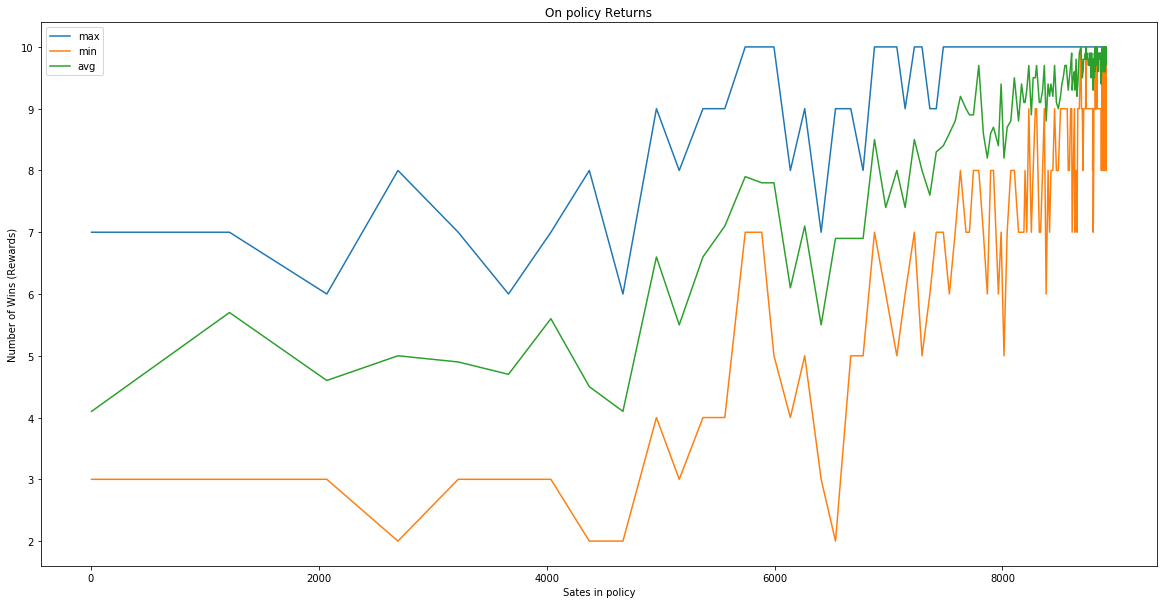

In [78]:
graphPlot(x, by, 'Sates in policy', 'Number of Wins (Rewards)', 'On policy Returns')

#### Rollouts vs Returns
The rollouts vs returns graph show similar structure with the returns converging to the best resutls at around 20000 iteration. 

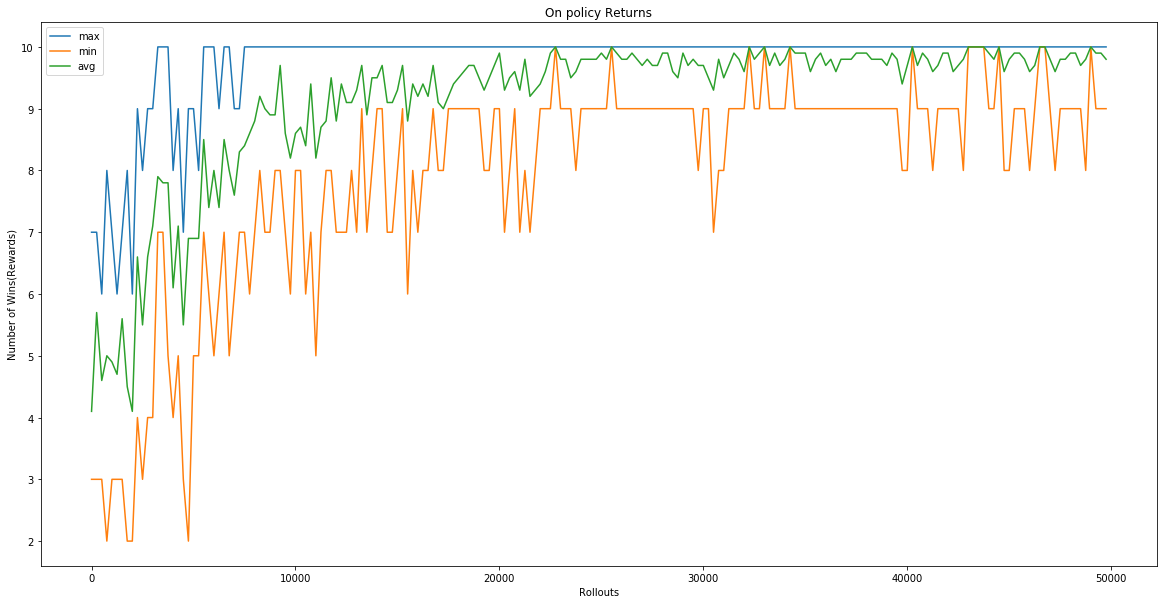

In [79]:
x_ = list(range(0,50000,250))
graphPlot(x_, by, 'Rollouts', 'Number of Wins(Rewards)', 'On policy Returns')

### Off Policy Monte Carlo

The off policy MC algorithm uses a behaviour policy to generate episodes. The behaviour policy can be any random $\epsilon$ greedy policy and it need not be constant. We generate a $\epsilon$ greedy policy with a random action uniformaly chosen to have the highest probablity. Since each state is visited atmost one time this corresponds to a uniformly chosend episode trajectory. The epsilong greedy policy genrated randomly for each episode. Weighted importance sampling is used with the weights being updated as the ratio of the desired $\epsilon$ greedy policy and the behaviour policy. Note the in the algorithm if the current action taken does not match the desired $\epsilon$ greedy action after the update opration has taken place that episode is discarded. The algorithm also assumes $\pi(a|s)$ = 1 for the best action in the desired policy even though it is an $\epsilon$ greedy policy. In practice this does not affect importance sampling ratio as theretically in the deterministic policy we will always take the action corresponding to the highest porbability. Similar to the On-policy the $Q(s,a)$ values are updated based on which player is currently playing. 

In [ ]:
def offMonteCarlo(env, eps, iterations = 1000, discount = 1, output_interval = 250):
    state_action_value = {}
    importance_ratio_sum = {}
    policy = epsPolicy(eps)
    x, by, tdy = [], [], []
    
    for rollouts in tqdm(range(iterations)):
        env.set_start_mark(environment.next_mark(env.mark))
        soft_policy = epsPolicy(eps)
        episode = genEpisode(env, soft_policy)
        G = 0
        W = 1
        for state, action, reward in list(reversed(episode)):
            G = discount * G + reward
            C = importance_ratio_sum[(state, action)] = importance_ratio_sum.get((state, action), 0) + W
            if state not in state_action_value:
                for action in soft_policy.state_dict[state].keys():
                    state_action_value.setdefault(state, {})[action] = 0
            Q = state_action_value[state][action]
            state_action_value[state][action] = Q + (W/C)*(G - Q)
            actions = state_action_value[state]
            if state not in policy.state_dict:
                policy.state_dict[state] = copy.deepcopy(soft_policy.state_dict[state])
            if state[-1] == 'O':
                policy.updateStatePolicy(state, max(actions.keys(), key = lambda x: actions[x]))
            elif state[-1] == 'X':
                policy.updateStatePolicy(state, min(actions.keys(), key = lambda x: actions[x]))
            if policy.getDetAction(state) != action:
                break
            W = W / soft_policy.state_dict[state][action]
        
        if rollouts % output_interval == 0:
            x += [len(policy.state_dict)]
            by += [testPolicy(policy, BaseAgent('X'), env)[0]]
            tdy += [testPolicy(policy, td_agent.TDAgent('X',0,0), env)[1]]
            
    return policy, x, by, tdy

In [23]:
offPolicy, x, by, tdy = offMonteCarlo(tenv, 0.5, iterations = 100000, discount = 0.9)

100%|██████████| 100000/100000 [02:26<00:00, 684.90it/s]


#### States vs Returns
This graph is similar to the on policy curve although there is more variance in the results and does not converge as smoothly to optimum value. There is a lot of variance in the returns as we approach near the end. 

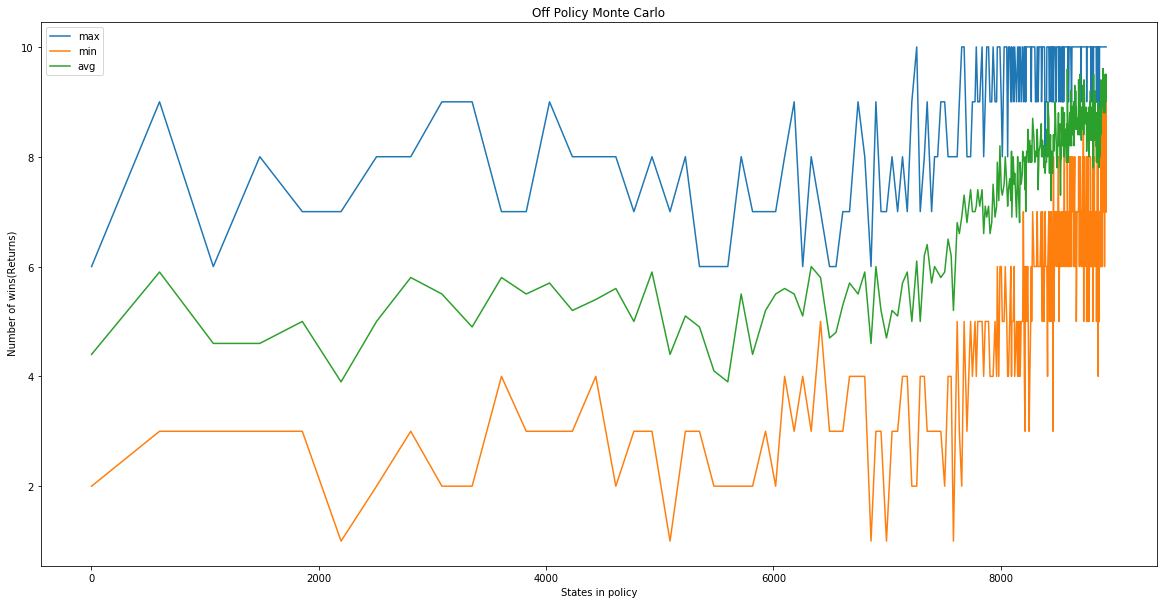

In [33]:
graphPlot(x, by, 'States in policy', ' Number of wins(Returns)', 'Off Policy Monte Carlo')

#### Rollouts vs Returns
Again, the convergence is slower than that of on-policy methods.

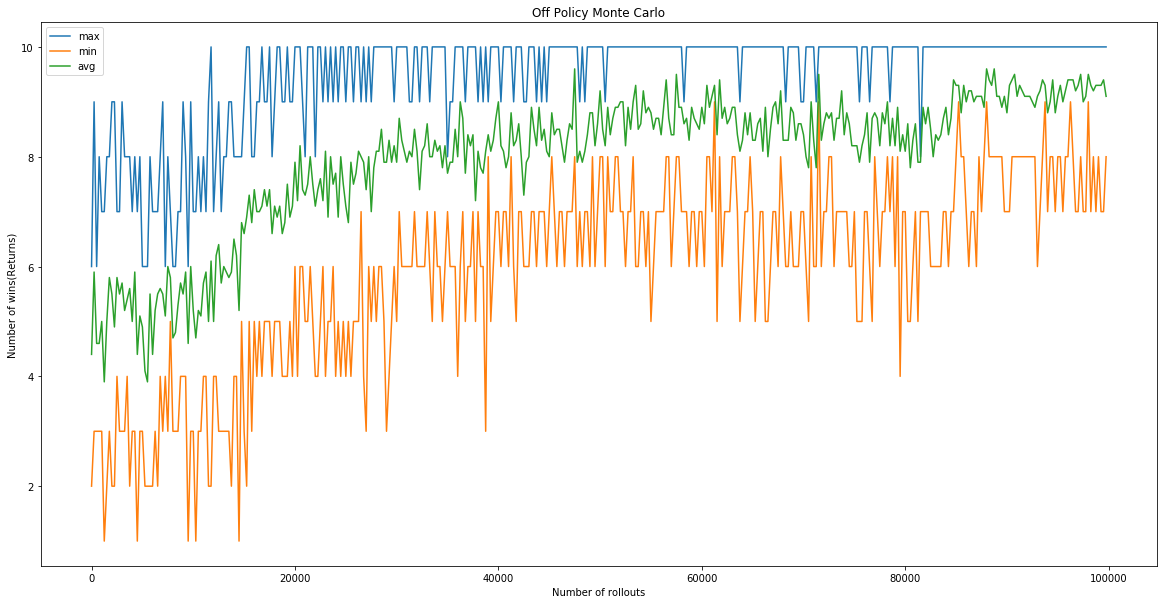

In [34]:
x_ = list(range(0, 100000, 250))
graphPlot(x_, by, 'Number of rollouts', 'Number of wins(Returns)', 'Off Policy Monte Carlo')

### Against Pretrained TD-Agent
Using a pretrained TD-Agent we can estimate how good our trained model is using MC methods. Ideally We should see a high number of draws in the result as both the agents play essentialy optimal moves. One point of consideration is that depending on how an agent trained it may prefer not losing to winning i.e. take less risky moves with highier chance of winning. However in general in my observation such moves are usually very explicit in Tic-Tac-Toe and often the safest option is also the most optimal play. Hence most of the time the a polcy is learned which leads to draws when both agets play optimally.

In [94]:
td_agent.load_model('best_td_agent.dat')
tdAgent = td_agent.TDAgent('O', 0, 0)
myagent = Agent('X',offPolicy)

In [97]:
w, l, d = playIter(myagent, tdAgent, tenv, iteration = 1000)

In [98]:
print("Wins Losses and Draws  by going First -", w,l,d)

Wins Losses and Draws  by going First - 0 0 1000


In [99]:
w, l, d = playIter(tdAgent, myagent, tenv, iteration = 1000)

In [100]:
print("Wins Losses and Draws  by going First -", w,l,d)

Wins Losses and Draws  by going First - 1000 0 0


### FrozenLake

#### Overview
Frozenlake requires an alogrithm to find a path between a source and a destination given a square grid with hazards. The objectve is to avoid the hazardous squares and reach the destination. 

#### Problem
If the problem was a deterministic one we could have gotten a policy that always results in a successfull path if it existed. However according the problem consists of a 'slippery surface' with probabilistic transitions between sqaures that do not always results in moving in the direction of action. This means that estimating the best action to take must take into consideration the most safest route to the destination. The model is first trained using TD to find the optimal path and then a trial run of 100 iteration is made and the number of times the agent reaches the target is calculated. It may so happen that during a pirtcular training phase the number of episodes generated with successfull completion(with the agent reaching the target) is not enough to properly train the model to converge i.e. the $Q(s,a)$ values for each state may not have been updated from its neighbors. 

#### Temporal Deifference Training
TD method estimates the $Q(s,a)$ values of each state-action pair environment. In TD we are succesively updating the value of state-action pair by its gradient in the direction of the optimal state-action value. This step is done iteratively over multiple episodes. How we estimate the gradient depends on what value of the next state and next action pair we take. 

1. If the next state-action pair is chosen randomly (based on some $\epsilon$ -greedy on policy) we get the S.A.R.S.A update. The TD update step is $$Q(s,a) = Q(s,a) + \alpha[r + Q(s',a') - Q(s,a)]$$
2. If the next state-action pair is chosen to be the maximum of all next state-action pairs we get the Q-learning update ste. $$Q(s,a) = Q(s,a) + \alpha[r + \max_aQ(s',a') - Q(s,a)]$$. 
3. If the next state-action prir is chosen to be the expected value of next state-action pairs we get expected S.A.R.S.A. $$Q(s,a) = Q(s,a) + \alpha[r + E[Q(s',a')] - Q(s,a)]$$.

In the algorithm as initialize the intial $Q(s,a)$ values with 0s. A random $\epsilon$ greedy policy is chosen as the on policy to learn during training and updated to reflect changes in $Q(s,a)$ values by choosing the max $Q(s,a)$ value in a state as the corresponding deterministic action in that state. The three methods for TD gradient update is tested. The $s'$ state in the algorithm is the state arrived at by using action $a$ on state $s$. In S.A.R.S.A a random action $a'$ is chosen as the next action. In Q-learning the next action is the best action i.e the one with the max $Q(s',a')$ value. In expected S.A.R.S.A the expected $Q(s',a')$ is calulated by taken multiplying the $Q(s',a')$ values with the $\epsilon$ greedy policy action probabilities.

#### Environment

8x8 Frozen lake environment. F represents frozen (safe), H represents Hazards, G is the goal state and S the start state. In all theree training Discount factor is taken as 1 i.e. rewards are undiscounted. This is so that the model learns the safest route to the goal and does not consider how many steps it takes to reach the goal.

In [6]:
from gym.envs.toy_text import frozen_lake
fLake = gym.make('FrozenLake8x8-v0')
fLake.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


### S.A.R.S.A

In [42]:
def sarsa(env, eps, alpha, iterations = 1000, discount = 1, output_interval = 250):
    policy = epsPolicy(eps)
    state_action = {}
    y = []
    for episodes in tqdm(range(iterations)):
        state = env.reset()
        done = False
        if state not in policy.state_dict:
            policy.generateRandomStatePolicy(state, [0, 1, 2 ,3])
        action = policy.getAction(state)
        while not done:
            next_state, reward, done, p = env.step(action)
            if next_state not in policy.state_dict:
                policy.generateRandomStatePolicy(next_state, [0, 1, 2, 3])
            next_action = policy.getAction(next_state)
            qsa = state_action.get(state, {}).get(action, 0)
            nqsa = state_action.get(next_state, {}).get(next_action, 0)
            state_action.setdefault(state, {})[action] = qsa + alpha * (reward + discount * nqsa - qsa)
            actions = state_action[state]
            best_action = max(list(actions.keys()), key = lambda x:actions[x])
            if best_action != action:
                policy.updateStatePolicy(state, best_action)
            state = next_state
            action = next_action
        if episodes % output_interval == 0:
            y += [evaluate(env, policy, 100)]
    return policy, y
            
            
        

Discount is taken to be 1 with $\alpha$ = 0.04 and $\epsilon$ = 0.2 in the epsilon greedy policy. With 60000 episodes of training we get the following results in the graph. The return for a successfull reach to destination is taken as 1. The average times we reach the goal given the calucated policy with each episode is shown. The policy converges to its optimal value early at around the 8000th iteration with the average ratio of reaching the destination at around 0.8 which means we reach the destination about 80% of the time. 

In [68]:
policy, y = sarsa(fLake, 0.2, 0.04, discount = 1, iterations = 60000)

100%|██████████| 60000/60000 [11:19<00:00, 88.30it/s] 


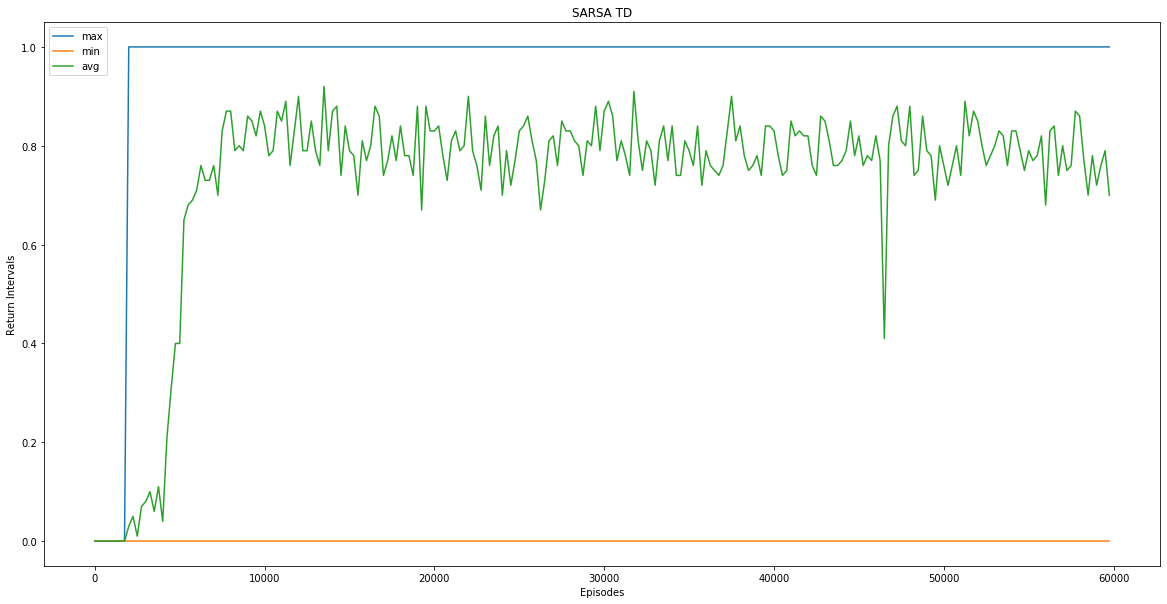

In [69]:
x = list(range(0, 60000, 250))
graphPlot(x, y, 'Episodes', 'Return Intervals', 'SARSA TD')

### Q-learning 

In [52]:
def qlearn(env, eps, alpha, iterations = 1000, discount = 1, output_interval = 250):
    policy = epsPolicy(eps)
    state_action = {}
    y = []
    for episodes in tqdm(range(iterations)):
        state = env.reset()
        done = False
        if state not in policy.state_dict:
            policy.generateRandomStatePolicy(state, [0, 1, 2 ,3])
        while not done:
            action = policy.getAction(state)
            next_state, reward, done, p = env.step(action)
            if next_state not in policy.state_dict:
                policy.generateRandomStatePolicy(next_state, [0, 1, 2, 3])
            next_action = policy.getDetAction(next_state)
            qsa = state_action.get(state, {}).get(action, 0)
            nqsa = state_action.get(next_state, {}).get(next_action, 0)
            state_action.setdefault(state, {})[action] = qsa + alpha * (reward + discount * nqsa - qsa)
            
            actions = state_action[state]
            best_action = max(list(actions.keys()), key = lambda x:actions[x])
            if best_action != action:
                policy.updateStatePolicy(state, best_action)
            state = next_state
        if episodes % output_interval == 0:
            y += [evaluate(env, policy, 100)]
    return policy, y   

Q-learning with $\alpha$ = 0.01 $\epsilon$ = 0.1 undiscounted training with 60000 iterations. As we can see the Q-learning update converges slower than the S.A.R.S.A update and to a less optimal policy. This may be because of the probablistic nature of the environment with non-deterministic transitions which does not give accurate results with max estimates in the Q-learning update.

In [65]:
qpolicy, y = qlearn(fLake, 0.1, 0.01, discount = 1, iterations = 60000)

100%|██████████| 60000/60000 [08:01<00:00, 124.59it/s]


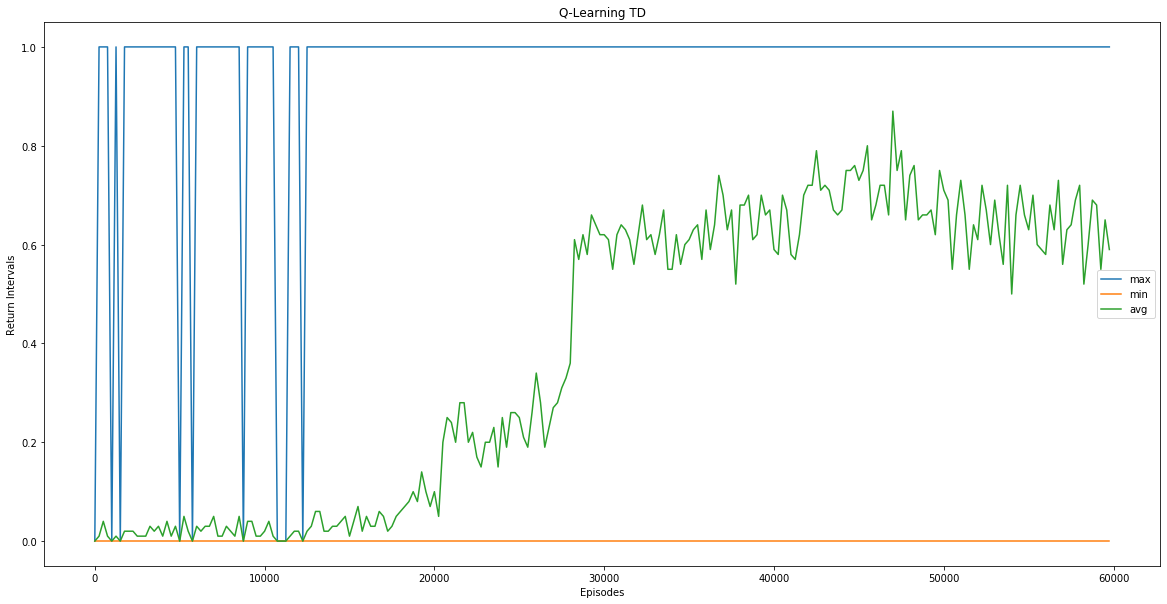

In [67]:
x = list(range(0, 60000, 250))
graphPlot(x, y, 'Episodes', 'Return Intervals', 'Q-Learning TD')

### Expected S.A.R.S.A

In [73]:
def exSarsa(env, eps, alpha, iterations = 1000, discount = 1, output_interval = 250):
    policy = epsPolicy(eps)
    state_action = {}
    y = []
    for episodes in tqdm(range(iterations)):
        state = env.reset()
        done = False
        if state not in policy.state_dict:
            policy.generateRandomStatePolicy(state, [0, 1, 2 ,3])
        while not done:
            action = policy.getAction(state)
            next_state, reward, done, p = env.step(action)
            if next_state not in policy.state_dict:
                policy.generateRandomStatePolicy(next_state, [0, 1, 2, 3])
            nqsa = 0
            for a in range(4):
                nqsa += policy.state_dict[next_state][a] * state_action.get(next_state, {}).get(a, 0)
            next_action = policy.getDetAction(next_state)
            qsa = state_action.get(state, {}).get(action, 0)
            state_action.setdefault(state, {})[action] = qsa + alpha * (reward + discount * nqsa - qsa)
            
            actions = state_action[state]
            best_action = max(list(actions.keys()), key = lambda x:actions[x])
            if best_action != action:
                policy.updateStatePolicy(state, best_action)
            state = next_state
        if episodes % output_interval == 0:
            y += [evaluate(env, policy, 100)]
    return policy, y   

Expected S.A.R.S.A with  $\alpha$ = 0.03 and $\epsilon$ = 0.1 on 60000 episodes of training. The expected S.A.R.S.A converges similar to the normal S.A.R.S.A algorithm

In [80]:
espolicy, y = exSarsa(fLake, 0.1, 0.03, discount = 1, iterations = 60000)

100%|██████████| 60000/60000 [13:53<00:00, 72.00it/s] 


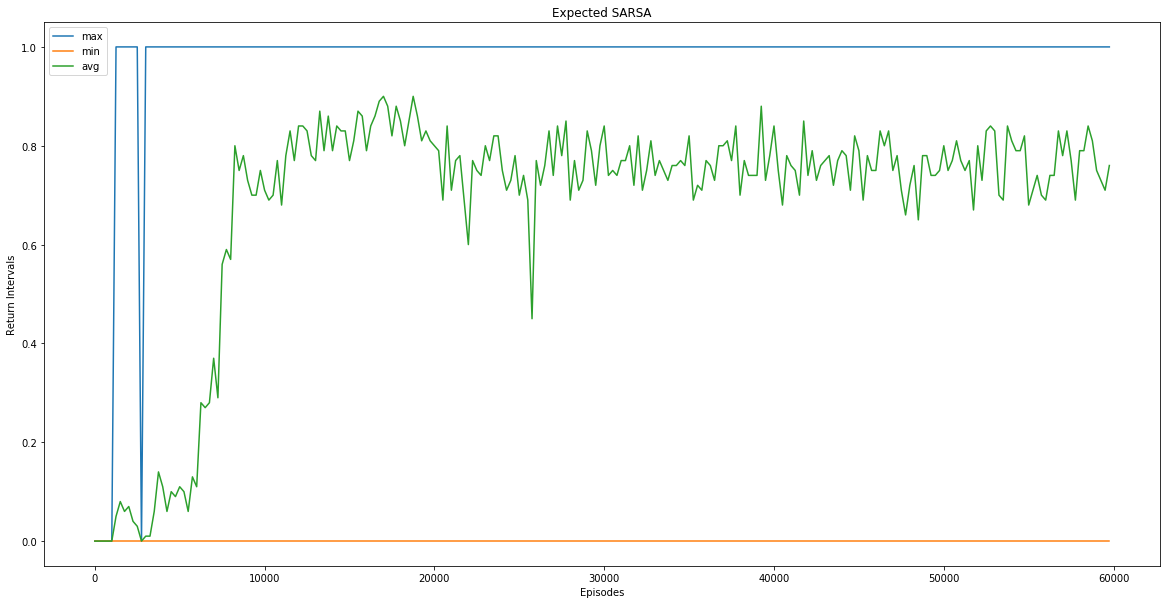

In [81]:
x = list(range(0, 60000, 250))
graphPlot(x, y, 'Episodes', 'Return Intervals', 'Expected SARSA')

## Breakout with DQN

In [1]:
from dqn_helper import processImg, ExperienceReplayBatch, step, testPlay
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
import copy
import time
import cv2
import gym

#### Overview
In this task we are asked to train a neural net to play the Atari 2600 game breakout. The game consists of a set of blocks at the top of the screen with a paddle at the bottom which can move left or right. The goal is to bounce a ball with the paddle at the bottom to break the blocks at the top. The balls trajectory is determined by hitting the ball with the paddle and succesively being bounced back from the block after breaking one or more of them. If the paddle fails to rebounce back the bal 5 times the game ends. We train a neural network to predict the action of the paddle given the state of the game as images. 

#### Problem
This is a continuous MDP with a large number of states where a state can be seen as the current state of the game. The large number of states and the data for each state makes it infeasible to store all of them explicitly or enumerate them. Instead we use a neural netword to essentially do function approximation of the $Q(s,a)$ values given the state. The neural network sould be able to recognize a state and give the best action to take on the state. This can be done in two ways, either by having a network that takse a state and action and predicts the corresoindign $Q(s,a)$ values, or the have a network that given a set of $s$ predicts the $Q(s,a)$ values for all $a$ in that state. We will use the second method. Actions on the paddle correspond to it moving left, right, staying in one position and firo command which is only used to launch a new ball after the old one is lost.

#### Formulation of the Problem
The heart of the learning algorithm consists of a convolution neural network which predicts the $Q(s,a)$ values given a state information. The state information is presented to the network as a stack of 4 the last four frames of the game. The last four frames is chosen so that the model can learn to interpret the direction and velocity of the moving ball. The last four frames are converted to grayscale rescaled and cropped to dimensions 84x84x4. There are 4 possible action so the output consists of a 4x1 vector for each of the $Q(s,a)$ values. The loss function is a defined as the squared difference of the reward added to the max estimate of the $Q(s',a')$ values, and the current $Q(s,a)$ values similar to the Q-learning update. $$L(\theta_i) = (r_i + \gamma \max_{a^{'}}Q(s',a';\theta_{i-1}) - Q(s,a;\theta_i))^2$$. The gradient of the loss is 
$$\delta_{\theta_i} L(\theta_i) = [(r_i + \gamma \max_{a^{'}}Q(s',a';\theta_{i-1}) - Q(s,a;\theta_i)]\delta_{\theta_i}Q(s,a;\theta_i)$$ 
A tensorflow network is set up with the folowing layers to get $Q(s,a)$ calculate loss nad do backprop using an Adam Optmizer. 
1. 16 filters with kernel size 8x8 and stride of 4 horziontally and vertically using activation ReLU.
2. 32 filters with kernel size 4x4 and stride of 2 horizontally and vertically using activation ReLu.
3. Flatten the output and feed to a 256 neuron Dense layer layer with activatio ReLU.
4. Output layer of 4 neurons with linear activation.

#### Experience Replay
We want the network to learn from previous episodes. Thus, instead of a single episode being generated at every step we keep a set of episodes in memory and extract samples from it in to train the network. This method is called experience replay. Experience replay samples are a 5-tuple $(s,a,r,s',d)$  where $s$ is the current state, $a$ is the action on the current state, $r$ is the reward on the transition, $s'$ is the next state on transition and $d$ is a boolean which is true is the final state is reached. This five tuple is generated for every transition in an episode and stored in the experience replay memory.

In [5]:
class DQN():
    
    def __init__(self, state_shape, actions, lrate = 0.00025, 
                 momentum = 0.95, discount = 0.95, save_file = None, load_file = None):
        tf.reset_default_graph()
        self._sess = tf.Session(config = config)
        self.state_shape = state_shape
        self.actions = actions
        self.save_file = save_file
        self.load_file = load_file
        self.discount = discount
        self._input = tf.placeholder(tf.float32, [None, state_shape[0], state_shape[1], state_shape[2]])
        self._action_value = tf.placeholder(tf.float32, [None, actions])
        self._initLayers()
        self.pred = self._predict()
        self.loss = keras.losses.MSE(self._action_value, self.pred)
        self.train_step = tf.train.AdamOptimizer(lrate).minimize(self.loss)
        #print(tf.global_variables())
        if load_file is None:
            self._sess.run(tf.global_variables_initializer())
        else:
            self.load()
            
    def _initLayers(self):
        self.conv1 = keras.layers.Conv2D(16, 8, strides = (4, 4), padding = 'valid', 
                                         activation = 'relu', 
                                         input_shape = self.state_shape,
                                         kernel_initializer = 'Zeros' 
                                        )
        self.conv2 = keras.layers.Conv2D(32, 4, strides = (2, 2), 
                                         padding = 'valid', 
                                         activation = 'relu',
                                         kernel_initializer = 'Zeros'
                                        )
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(256, activation = 'relu',
                                         kernel_initializer = 'Zeros',
                                         bias_initializer = 'Zeros'
                                        )
        self.dense2 = keras.layers.Dense(self.actions,
                                         kernel_initializer = 'Zeros',
                                         bias_initializer = 'Zeros'
                                        )
        
    def _predict(self):
        x = self.flatten(self.conv2(self.conv1(self._input)))
        x = self.dense2(self.dense1(x))
        return x
        
    def predict(self, state_data):
        state_data_float = state_data/255
        assert state_data[0].shape == self.state_shape
        pred = self._sess.run([self.pred], feed_dict = {
            self._input: state_data_float
        })
        return pred
    
    def train(self, replay_batch):
        next_state_batch = np.array([i[-2] for i in replay_batch], dtype = np.float32)
        current_state_batch = np.array([i[0] for i in replay_batch], dtype = np.float32)
        sess = self._sess
        next_state_pred = sess.run([self.pred], feed_dict = {
            self._input: next_state_batch/255
        })
        current_state_pred = sess.run([self.pred], feed_dict = {
            self._input: current_state_batch/255
        })[0]
        
        #print(current_state_pred.shape)
        best_actions = [np.max(actions) for actions in next_state_pred[0]]
        #print(len(best_actions))
        for i, rb in enumerate(replay_batch):
            if not rb[-1]:
                current_state_pred[i,rb[1]] = rb[2] + self.discount * best_actions[i]
            else:
                current_state_pred[i,rb[1]] = rb[2]
        _, loss = sess.run([self.train_step, self.loss], feed_dict = {
            self._action_value: current_state_pred,
            self._input: current_state_batch/255
        })
        #print(np.sum(loss))
        return np.sum(loss)/len(loss)
    
    def save(self):
        assert self.save_file != None
        saver = tf.train.Saver(var_list = tf.global_variables())
        saver.save(self._sess, self.save_file)
        
    def load(self):
        assert self.load_file != None
        loader = tf.train.Saver()
        loader.restore(self._sess, self.load_file)
        
    def __del__(self):
        self._sess.close()

####  Training the network
The network is trained by getting batches of experience from the experience replay memory and feeding it to the network for it to train. A DQN update or train operation is of the follwing steps.
1. Do forward prop on $s$ and $s'$ for each experience in the experience replay. 
2. Select the best action as the action with the highest $Q(s',a')$ value if $s$ is not final state and set $y_i = r_i + \gamma \max_{a^{'}} Q(s',a')$. Otherwise set $y_i = r_i$.
3. Train the network by doing backprop on loss of $(y_i - Q(s,a))^2$ on only the output neuron for $a$. This can be done by setting the remaining $y_i$ values to $Q(s,a)$ so that the the gradient for them is zero.

The DQN training network used is a slight modification on the 'Playing Atari with Deep Reinforcement Learning' paper where the used experience replay sets of size 50000. Due to lack of resources on my system I set the minimum replay size of 2500. To ensure that experiences are sampled from new episodes I have set the experience replay memory to be cleared after it crosses 4000 entries. These numbers can be adjusted based on the reources available. The overall algorithm is stated as. 

1. Generate episodes by starting at the start state, and then choosing a random action with probability $\epsilon$, or using the DQN to predict the best action on each state. Populate the experience replay memory as five tuples of $(s, a, r, s', d)$ as explained above.
2. If the number of experiences stored exceeds 2500, sample sets of 48 experience from the experience buffer and update(train) the DQN using the sets a certain number of times. 
3. Once the exeperience buffer crosses 4000 clear the experience memory. 
4. Repeat steps 1,2,3 for a certain number of episodes to train the network.

In addition to the above algorithm we can make modifications by adding epsilon decay so that as the training progresses we are choosing more actions taken by the DQN instead of randomly exploring actions.

In [6]:
def dqLearn(env, exp_buf, dqn, eps, epsdecay = 0.9994, episodes = 10000, 
            train_len = 200, min_buf_size = 2500, buf_clear_thres = 4000,
            render_interval = 5, batch_size = 48):
    
    for ep in range(episodes):
        
        print('Episode ', ep, "Current Replay Size", exp_buf.current_buf_size)
        env.reset()
        init_state, a, r, p = env.step(1)
        prev_state = processImg([init_state, init_state, init_state, init_state])
        done = False
        
        while not done:
            next_action_choice = np.random.choice([0,1], p = [eps, 1-eps])
            if next_action_choice == 0:
                next_action = np.random.choice([0,1,2,3])
            else:
                next_action = np.argmax(dqn.predict(np.array([prev_state]))[0])
            replay = step(env, next_action)
            done = replay[-1] 
            replay = [prev_state] + replay
            exp_buf.store_replay(replay)
            prev_state = replay[-2]
            
        if exp_buf.current_buf_size >= min_buf_size:
            avg_loss = 0
            for _ in tqdm(range(train_len)):
                train_batch = exp_buf.getRandomBatch(batch_size)
                avg_loss += dqn.train(train_batch)
            eps = max(0.1, epsdecay * eps)
            print('Average Loss', avg_loss/train_len)
            dqn.save()
            if render_interval !=0 and ep % render_interval == 0:
                print("Reward ", testPlay(env, dqn, render = True))
#             else:
#                 print("Reward ", play(env, dqn))
                
        if exp_buf.current_buf_size >= buf_clear_thres:
            exp_buf.reset()
        
    

### Training The network

In [7]:
benv = gym.make('Breakout-v4')
exp_buf = ExperienceReplayBatch(5000)
dqn = DQN((84, 84, 4), 4, save_file = 'my_model9', load_file = 'my_model8')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from my_model8


In [ ]:
dqLearn(benv, exp_buf, dqn, 0.9, render_interval=10)

### Testing The Network
Note that testing is done on a trained network of around 10 hrs with limited capabilites as described above. The maxmum score, minumum score and averaege score over a period of runs is shown.

In [11]:
scores = []
for i in range(1000):
    scores.append(testPlay(benv, dqn, render = False))
print("Minimum Score = ", min(scores), "Maximum Score = ", max(scores), "Average Score = ", sum(scores)/len(scores))

Minimum Score =  2.0 Maximum Score =  17.0 Average Score =  6.543


From the minimum and maximum we can see that the game has a tendency to devieate highly from its mean value signifying that when the game goes well it goes really well or otherwise the game goes badly.